Marie McCrary

This notebook loads river data and plots it using pandas

In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import datetime
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm

%matplotlib inline

## River Temperatures
Read in data from two datasets: ArcticGRO (the Water Quality dataset) and GEMS. <br />
ArcticGRO -> df_a <br />
ArcticGRO temperatures -> Temp <br />
GEMS -> df_g <br />
GEMS temperatures -> VALUE_VALEUR

### Some notes about this data:
1. The data were collected over several decades, and the data were not always consistently collected
2. The temperature data has large temporal gaps and few datapoints are in the ArcticGRO dataset

In [2]:
d1 = pd.read_csv('~/Research/Rivers/River_temperature/GEMS_Mackenzie_Temperature.csv', header=0, parse_dates=[1], index_col=[1]) 
df_g = pd.DataFrame(data=d1) 
df_g = df_g.loc[df_g.VARIABLE == 'TEMPERATURE WATER']

d2 = pd.read_csv('~/Research/Rivers/River_temperature/ArcticGRO_Water_Quality_Data_Mackenzie.csv', header=8, parse_dates=[2], index_col=[2]) 
df_a = pd.DataFrame(data=d2) 
df_a=df_a.drop([df_a.index[0]])

In [3]:
df_a.index = pd.to_datetime(df_a.index)

In [4]:
# Convert to float
df_a['Temp'] = df_a.Temp.astype(float, errors = 'raise')
df_g['VALUE_VALEUR'] = df_g.VALUE_VALEUR.astype(float, errors = 'raise')

Combine both datasets to clean up code. All temperature data are in temperature dataframe.

In [5]:
series1 = pd.Series(df_a.Temp)
series2 = pd.Series(df_g.VALUE_VALEUR)
series2 = series2.rename('Temp')
temperature = series1.append(series2)
temperature.index

DatetimeIndex(['2003-06-24 00:00:00', '2004-03-24 00:00:00',
               '2004-06-17 00:00:00', '2004-06-22 00:00:00',
               '2004-07-13 00:00:00', '2004-08-04 00:00:00',
               '2004-08-25 00:00:00', '2004-09-08 00:00:00',
               '2005-03-16 00:00:00', '2005-06-14 00:00:00',
               ...
               '2012-07-16 14:00:00', '2012-09-13 14:10:00',
               '2013-06-03 12:20:00', '2013-07-18 12:35:00',
               '2014-06-04 14:20:00', '2014-09-10 13:30:00',
               '2015-06-08 14:10:00', '2015-07-07 15:05:00',
               '2016-05-30 13:25:00', '2016-07-27 14:30:00'],
              dtype='datetime64[ns]', length=1553, freq=None)

In [242]:
temp_grouped = temperature.groupby(temperature.index.month)

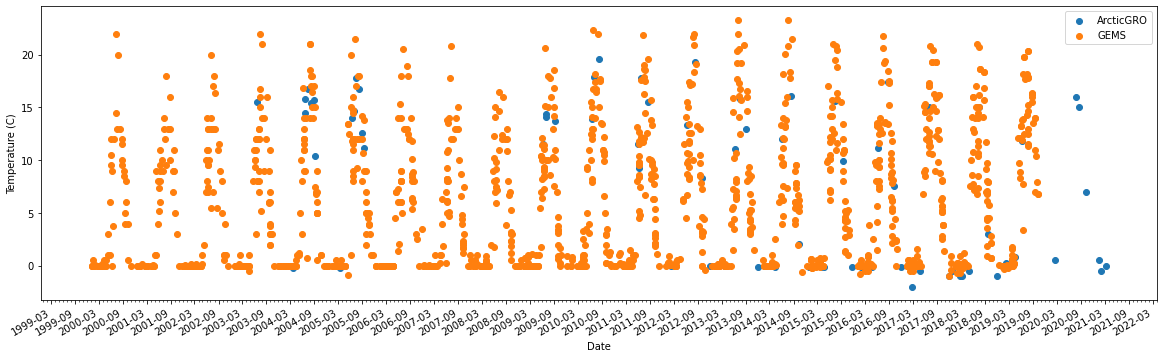

In [243]:
fig, ax = plt.subplots(figsize=(20,6))

ax.scatter(df_a.index.values, df_a.Temp, label = 'ArcticGRO')
ax.scatter(df_g.index.values, df_g.VALUE_VALEUR, label = 'GEMS')
ax.set(xlabel="Date",
       ylabel="Temperature (C)")

# Major ticks every 6 months.
fmt_half_year = mdates.MonthLocator(interval=6)
ax.xaxis.set_major_locator(fmt_half_year)

# Minor ticks every month.
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)

# Text in the x axis will be displayed in 'YYYY-mm' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them.
fig.autofmt_xdate()

ax.legend()
plt.show()


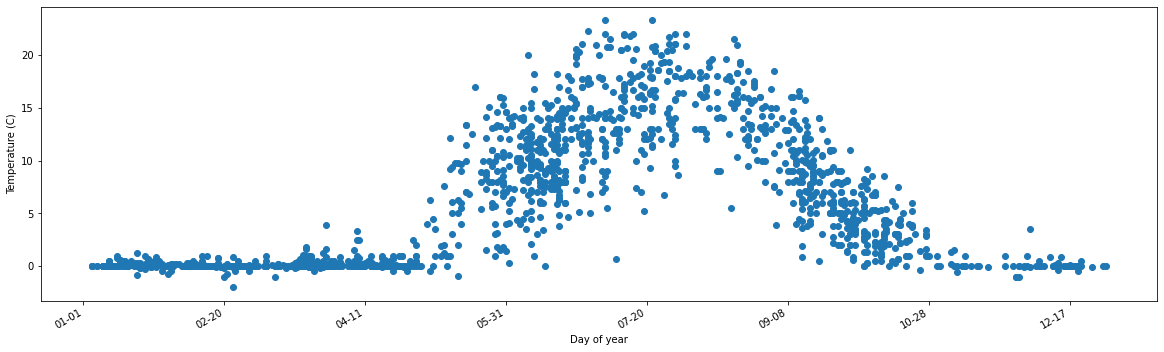

In [244]:
fig, ax = plt.subplots(figsize=(20,6))

ax.scatter(temperature.index.day_of_year, temperature)

ax.set(xlabel="Day of year",
       ylabel="Temperature (C)")


# # Text in the x axis will be displayed in 'YYYY-mm' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

# # Rotates and right aligns the x labels, and moves the bottom of the
# # axes up to make room for them.
fig.autofmt_xdate()

# ax.legend()
plt.show()



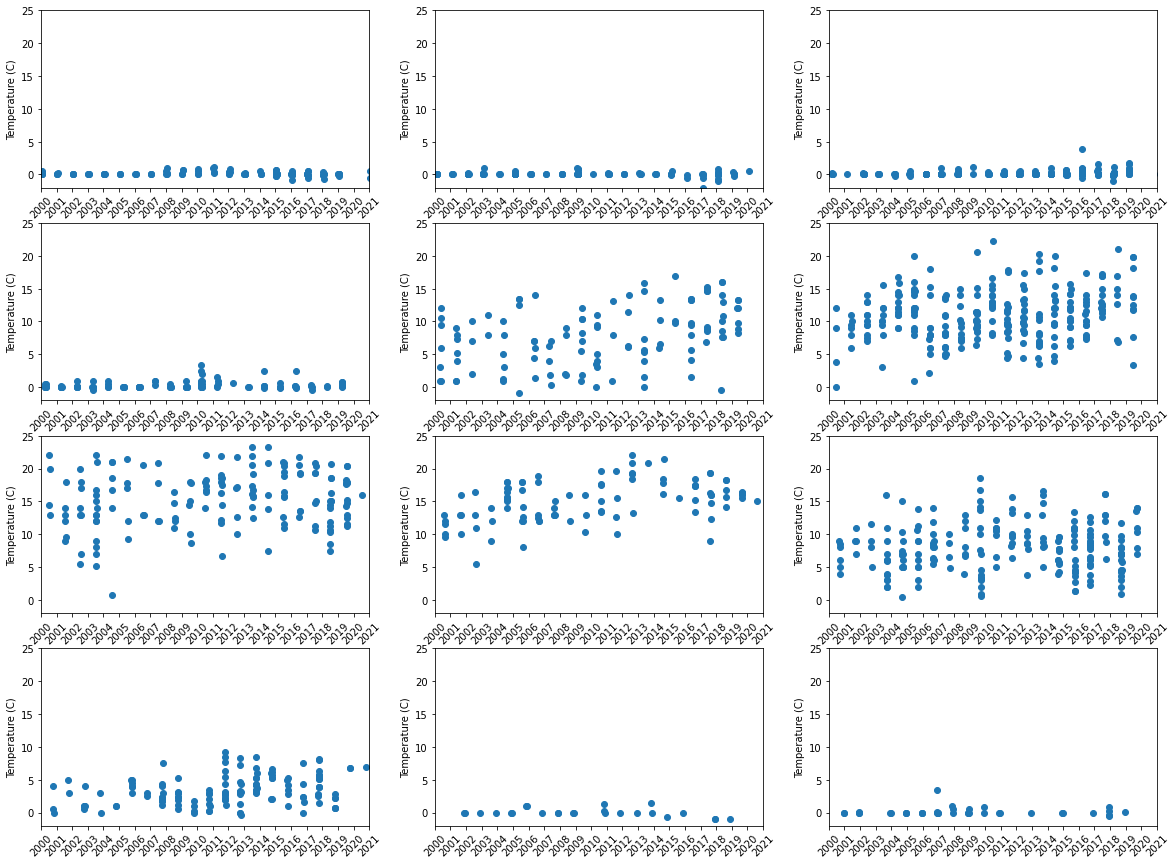

In [245]:

fig, axs = plt.subplots()
axs.set_axis_off()
fig.set_figheight(15)
fig.set_figwidth(20)

left = datetime.date(2000, 1, 1)
right = datetime.date(2021, 1, 1)


for i in range(1,13):
    axs = fig.add_subplot(4,3,i)
    axs.set_ylim([-2,25])
    axs.set_xlim([left, right])
    plt.scatter(temp_grouped.get_group(i).index, temp_grouped.get_group(i))
   
    # Major ticks every year.
    fmt_year = mdates.MonthLocator(interval=12)
    axs.xaxis.set_major_locator(fmt_year)
    axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation = 45)
    axs.set(ylabel="Temperature (C)")

plt.show()

In [259]:
temp_trend = []
temp_nrmse = []
for i in range(1,13):
    #To perform the linear regression we need the dates to be numeric
    date_ord = temp_grouped.get_group(i).index(datetime.date.toordinal)

    # perform regression
    coefficients, residuals, _, _, _ = np.polyfit(range(len(date_ord)),temp_grouped.get_group(i),1,full=True)
    mse = residuals[0]/(len(temp_grouped.get_group(i).index))
    nrmse = np.sqrt(mse)/(temp_grouped.get_group(i).max() - temp_grouped.get_group(i).min())
    temp_trend.append(coefficients[0])
    temp_nrmse.append(nrmse)
    print('Temperature Trend = ' + str(coefficients[0]))
    print('NRMSE: ' + str(nrmse))
    
fig = plt.figure(figsize = (10, 5))
#  Bar plot
plt.bar(range(1,13), temp_trend)

plt.xlabel("Month")
plt.ylabel("Temperature - degrees C per year")
plt.title("Trend in Temperatures (NOT Anomalies)")

plt.show()

TypeError: 'DatetimeIndex' object is not callable

### Mean temperature for each month:
monthly_mean_temperature is the mean for each month in the series (237 months). <br />
monthly_mean is the mean of all the monthly means for each month.

In [139]:
monthly_mean_temperature = temperature.resample('M').mean().dropna()
monthly_mean = monthly_mean_temperature.groupby(monthly_mean_temperature.index.month).agg('mean')
monthly_min_temperature = temperature.resample('M').min().dropna()
monthly_min = monthly_min_temperature.groupby(monthly_min_temperature.index.month).agg('min')
monthly_max_temperature = temperature.resample('M').max().dropna()
monthly_max = monthly_max_temperature.groupby(monthly_max_temperature.index.month).agg('max')


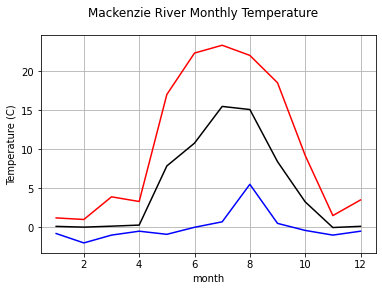

In [144]:
fig, ax = plt.subplots()
fig.suptitle('Mackenzie River Temperatures')

ax.plot(monthly_mean, label = 'Mean', color = 'black')
ax.plot(monthly_min, label = 'Min', color = 'blue')
ax.plot(monthly_max, label = 'Max', color = 'red')
#ax.fill_between(range(1,13), monthly_min_temperature, monthly_max_temperature, color = 'gray', alpha = 0.25)
ax.set(ylabel = "Temperature (C)", xlabel = 'month')
plt.grid()

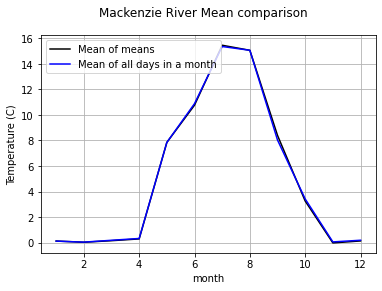

In [227]:
monthly_mean_old = temperature.groupby(temperature.index.month).agg('mean')

fig, ax = plt.subplots()
fig.suptitle('Mackenzie River Mean comparison')

ax.plot(monthly_mean, label = 'Mean of means', color = 'black')
ax.plot(monthly_mean_old, label = 'Mean of all days in a month', color = 'blue')
ax.set(ylabel = "Temperature (C)", xlabel = 'month')
ax.legend()
plt.grid()
# They are very close

## River Temperature Anomalies

In [55]:
anomaly = []

for i in range(1,13):
    diff = monthly_mean_temperature.groupby(monthly_mean_temperature.index.month).get_group(i) - monthly_mean[i]
    anomaly.append(diff)

In [56]:
anomaly

[2000-01-31   -0.030184
 2001-01-31   -0.065899
 2002-01-31   -0.115899
 2003-01-31   -0.115899
 2004-01-31   -0.115899
 2005-01-31   -0.115899
 2006-01-31   -0.115899
 2007-01-31   -0.082565
 2008-01-31    0.224101
 2009-01-31    0.234101
 2010-01-31    0.209101
 2011-01-31    0.559101
 2012-01-31    0.217435
 2013-01-31   -0.090899
 2014-01-31    0.009101
 2015-01-31    0.035530
 2016-01-31   -0.109899
 2017-01-31   -0.051454
 2018-01-31   -0.202565
 2019-01-31   -0.159613
 2021-01-31   -0.115899
 Name: Temp, dtype: float64,
 2000-02-29   -0.019858
 2001-02-28   -0.019858
 2002-02-28    0.002364
 2003-02-28    0.151570
 2004-02-29   -0.019858
 2005-02-28    0.021808
 2006-02-28   -0.019858
 2007-02-28   -0.019858
 2008-02-29   -0.019858
 2009-02-28    0.187284
 2010-02-28   -0.019858
 2011-02-28    0.020142
 2012-02-29    0.046808
 2013-02-28    0.055142
 2014-02-28   -0.019858
 2015-02-28    0.064142
 2016-02-29   -0.289858
 2017-02-28   -0.531858
 2018-02-28   -0.067358
 2019-02-28

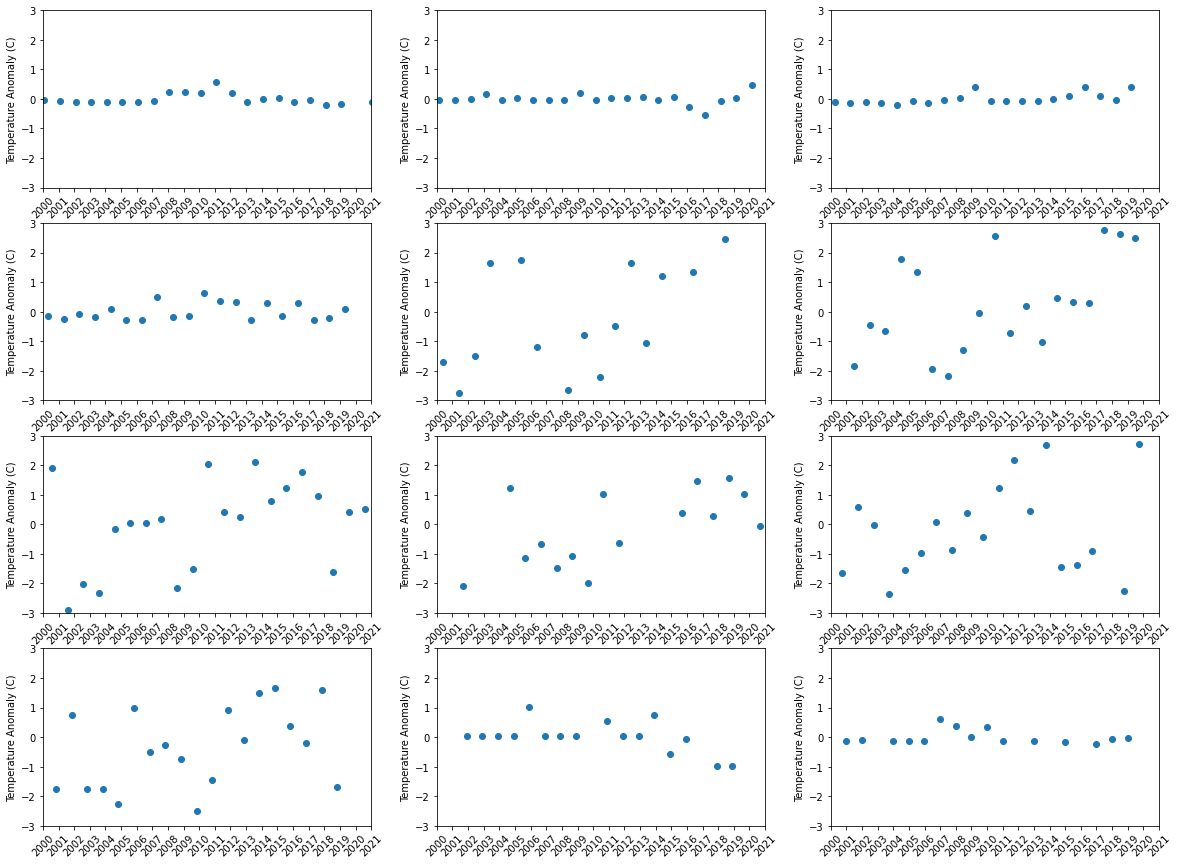

In [133]:

fig, axs = plt.subplots()
axs.set_axis_off()
fig.set_figheight(15)
fig.set_figwidth(20)

left = datetime.date(2000, 1, 1)
right = datetime.date(2021, 1, 1)


for i in range(0,12):
    axs = fig.add_subplot(4,3,i+1)
    axs.set_ylim([-3, 3])
    axs.set_xlim([left, right])
    plt.scatter(anomaly[i].index, anomaly[i])
   
    # Major ticks every year.
    fmt_year = mdates.MonthLocator(interval=12)
    axs.xaxis.set_major_locator(fmt_year)
    axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation = 45)
    axs.set(ylabel="Temperature Anomaly (C)")

plt.show()

## Linear Regression
monthly_mean_temperature is the mean for each month in the series (237 months). <br />

In [134]:
#To perform the linear regression we need the dates to be numeric
date_ord = monthly_mean_temperature.index.map(datetime.date.toordinal)
coefficients_mm, residuals, _, _, _ = np.polyfit(range(len(date_ord)),monthly_mean_temperature,1,full=True)
mse = residuals[0]/(len(monthly_mean_temperature.index))
nrmse = np.sqrt(mse)/(monthly_mean_temperature.max() - monthly_mean_temperature.min())
print('Temperature Trend of whole record by removing the mean = ' + str(coefficients_mm[0]))
print('NRMSE: ' + str(nrmse))

Temperature Trend of whole record by removing the mean = 0.008940150002333324
NRMSE: 0.2704304888449095


In [233]:
Monthly_mean_temperature_grouped = monthly_mean_temperature.groupby(monthly_mean_temperature.index.month)

In [234]:

monthly_trend = []
monthly_nrmse = []
for i in range(1,13):
    #To perform the linear regression we need the dates to be numeric
    date_ord = monthly_mean_temperature_grouped.get_group(i).index.map(datetime.date.toordinal)

    # perform regression
    coefficients, residuals, _, _, _ = np.polyfit(range(len(date_ord)),monthly_mean_temperature_grouped.get_group(i),1,full=True)
    mse = residuals[0]/(len(monthly_mean_temperature_grouped.get_group(i).index))
    nrmse = np.sqrt(mse)/(monthly_mean_temperature_grouped.get_group(i).max() - monthly_mean_temperature_grouped.get_group(i).min())
    monthly_trend.append(coefficients[0])
    monthly_nrmse.append(nrmse)
    print('Temperature Trend = ' + str(coefficients[0]))
    print('NRMSE: ' + str(nrmse))
 

Temperature Trend = 0.02036993717117939
NRMSE: 0.1969555263401697
Temperature Trend = -0.0016056850671757486
NRMSE: 0.1726793627691307
Temperature Trend = 0.04916268496858557
NRMSE: 0.18408796326571572
Temperature Trend = 0.0908682745825603
NRMSE: 0.1912147748833069
Temperature Trend = 0.2660347557204699
NRMSE: 0.2100569214466085
Temperature Trend = 0.20263829650402224
NRMSE: 0.19311931723953482
Temperature Trend = 0.09779106932029066
NRMSE: 0.27438864204880276
Temperature Trend = 0.24839718614718628
NRMSE: 0.19290551128678973
Temperature Trend = 0.12125529464995308
NRMSE: 0.26831911174699075
Temperature Trend = 0.17069476079476079
NRMSE: 0.22168369907299154
Temperature Trend = 0.09530086580086577
NRMSE: 0.22804226073943687
Temperature Trend = 0.06794480519480517
NRMSE: 0.21063969941080116


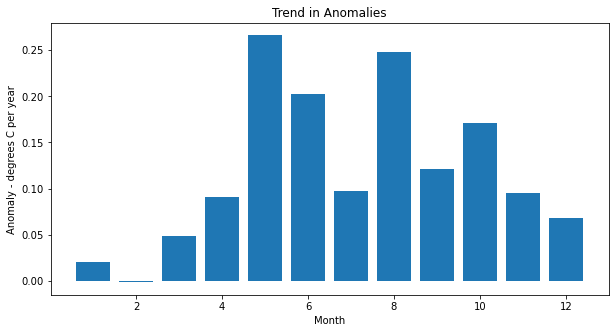

In [235]:
fig = plt.figure(figsize = (10, 5))
#  Bar plot
plt.bar(range(1,13), monthly_trend)

plt.xlabel("Month")
plt.ylabel("Anomaly - degrees C per year")
plt.title("Trend in Anomalies")

plt.show()

In [269]:
temp_grouped.get_group(1).index

DatetimeIndex(['2013-01-26 00:00:00', '2015-01-21 00:00:00',
               '2016-01-31 00:00:00', '2021-01-14 00:00:00',
               '2021-01-28 00:00:00', '2000-01-30 14:15:00',
               '2001-01-28 07:55:00', '2007-01-25 11:05:00',
               '2008-01-09 13:46:00', '2010-01-15 13:00:00',
               ...
               '2005-01-31 10:20:00', '2006-01-16 15:30:00',
               '2008-01-09 09:58:00', '2012-01-03 09:45:00',
               '2013-01-19 12:05:00', '2015-01-21 10:30:00',
               '2016-01-19 11:30:00', '2017-01-31 13:50:00',
               '2018-01-30 11:40:00', '2019-01-22 11:25:00'],
              dtype='datetime64[ns]', length=116, freq=None)